# create glacier inputs for SPHY v3.x

#### TODO build inputs from scratch
#### currently using example SPHY v2.x inputs as a starting place

In [18]:
import os, glob
import pcraster as pcr
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs
import cartopy.io.img_tiles

import pcr_tool 

import rasterio.features
from shapely.geometry import shape
import geopandas as gpd


In [2]:
### use Trisuli example model

In [3]:
# user inputs
epsg = 32645 # EPSG for clone.map
epsg_check = 4326 # EPSG for checking projections # CHECK if needed
missing_value = -9999 # missing_value


In [4]:
# read in Trisuli domain files
#- clonemap
path_clone = os.path.join('..', 'examples', 'Trisuli', 'input', 'clone.map') # path to clone.map (example map 1)
map_clone = pcr_tool.clonemap(epsg = epsg)
map_clone.load_clonemap(path = path_clone)
pcr.aguila(map_clone.clonemap)

# put into xarray
da_clone = map_clone.to_xarray(varname = 'clone') # 'field' is not required for clonemap as it is already defined when creating the class variable, 'map_clone'

In [5]:
# create index array to be used to define grid cell values
# (currently starting from 1, top-left, and filling rows. add options to define regionally / globally)

ids_arr = np.arange(1, da_clone.x.size*da_clone.y.size + 1, 1)
ids_arr.size
ids_2d = np.reshape(ids_arr, (-1, da_clone.y.size))

In [6]:
# create xarray dataset
sphy_dom = da_clone.to_dataset()

In [7]:
# assign ids to xarray dataset for organization (MOD_ID)
sphy_dom = sphy_dom.assign(MOD_ID = (['x','y'], ids_2d))

In [8]:
sphy_dom

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 749, x: 485)
Coordinates:
  * y        (y) float64 6kB 3.065e+06 3.065e+06 ... 3.215e+06 3.215e+06
  * x        (x) float64 4kB 2.904e+05 2.906e+05 ... 3.87e+05 3.872e+05
Data variables:
    clone    (y, x) uint8 363kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    MOD_ID   (x, y) int64 3MB 1 2 3 4 5 6 ... 363261 363262 363263 363264 363265

GLACIER CSV TABLE. This table contains a unique cell id and is based on a unique combination of the 
model grid id and glacier id. Table columns should be: "U_ID, MOD_ID, GLAC_ID, MOD_H, GLAC_H, 
DEBRIS (1=Yes, 0= Clean Ice), FRAC_GLAC".   

##### U_ID: unique ID; combination of MOD_ID and GLAC_ID
##### MOD_ID: nominal map with a unique ID for each model grid cell.
##### GLAC_ID: nominal map with a unique ID for each glacier.  
##### MOD_H: model cell DEM elevation
##### GLAC_H: glacier elevation
##### DEBRIS (0/1): flag indicating whether debris-covered
##### FRAC_GLACIER: fraction of grid cell as glacier

difference between MOD_H and GLAC_H determine the glacier thickness

https://groups.google.com/g/sphy-model-user/c/MsGW8QEp67U/m/yHNtrZd9AwAJ

In [10]:
# read in Trisuli glacier files
#- glacier fraction
path_glacfrac = os.path.join('..', 'examples', 'Trisuli', 'input', 'glacfrac.map')
da_glacfrac = map_clone.to_xarray(field = path_glacfrac, varname = 'glacfrac') 
#- clean ice
path_glacfrac_ci = os.path.join('..', 'examples', 'Trisuli', 'input', 'glacfrac_ci.map')
da_glacfrac_ci = map_clone.to_xarray(field = path_glacfrac_ci, varname = 'glacfrac_ci') 
#- debris-covered ice
path_glacfrac_db = os.path.join('..', 'examples', 'Trisuli', 'input', 'glacfrac_db.map')
da_glacfrac_db = map_clone.to_xarray(field = path_glacfrac_db, varname = 'glacfrac_db') 


In [11]:
# add glacier data to xarray dataset
sphy_dom = sphy_dom.assign(glacfrac = da_glacfrac)
sphy_dom = sphy_dom.assign(glacfrac_ci = da_glacfrac_ci)
sphy_dom = sphy_dom.assign(glacfrac_db = da_glacfrac_db)

In [19]:
sphy_dom.glacfrac

<xarray.DataArray 'glacfrac' (y: 749, x: 485)> Size: 1MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y        (y) float64 6kB 3.065e+06 3.065e+06 ... 3.215e+06 3.215e+06
  * x        (x) float64 4kB 2.904e+05 2.906e+05 ... 3.87e+05 3.872e+05

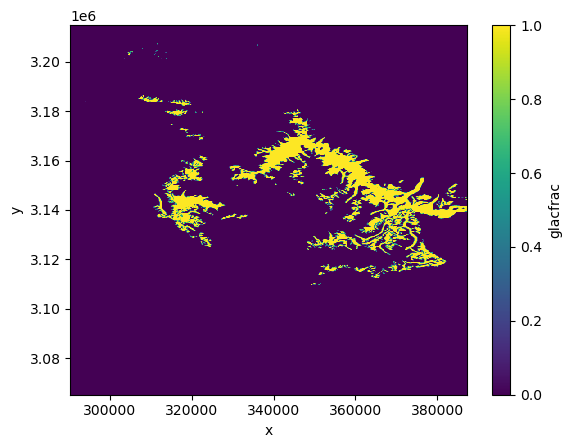

In [13]:
da_glacfrac.plot.imshow()

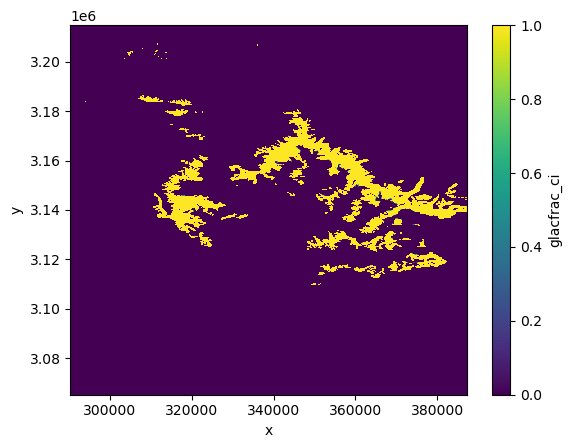

In [14]:
da_glacfrac_ci.plot.imshow()

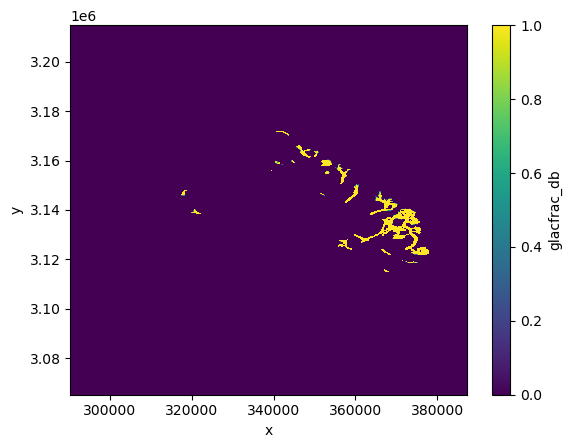

In [15]:
da_glacfrac_db.plot.imshow()

In [109]:
# convert Xarray DataArray to spatial polygons
from shapely.geometry import Polygon

y_vec = sphy_dom['y'].values # extract y dimension data from Xarray
x_vec = sphy_dom['x'].values # extract x dimension data from Xarray

x_inc = x_vec[1] - x_vec[0] # assumes uniform increment
y_inc = y_vec[1] - y_vec[0] # assumes uniform increment

# Create a list of polygons from Xarray dataset
polygons = []
for i in range(len(y_vec)):
    for j in range(len(x_vec)):
        polygon = Polygon([(x_vec[j] - x_inc / 2, y_vec[i] + y_inc / 2),
                           (x_vec[j] + x_inc / 2, y_vec[i] + y_inc / 2),
                           (x_vec[j] + x_inc / 2, y_vec[i] - y_inc / 2),
                           (x_vec[j] - x_inc / 2, y_vec[i] - y_inc / 2)])
        polygons.append(polygon)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry = polygons, crs = 'epsg:' + str(epsg))

for var_name in sphy_dom.data_vars:
    gdf[var_name] = sphy_dom[var_name].values.flatten()


<Axes: >

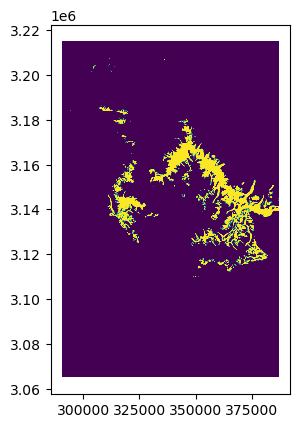

In [48]:
gdf.plot(column='glacfrac', cmap = "viridis")

#### build glacier inputs from Randolph Glacier Inventory (RGI) v7

In [51]:
# read in RGI (set to South Asia East region)
rgi = gpd.read_file(r'/Users/brom374/Library/CloudStorage/OneDrive-PNNL/Documents/Datasets/RGI/RGI2000-v7.0-G-global/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp').to_crs('epsg:' + str(epsg))


In [168]:
# intersect polygons and compute intersection area
intersection = gpd.overlay(gdf, rgi, how = 'intersection')
intersection['area_int'] = intersection['geometry'].area
intersection = intersection[['MOD_ID', 'area_int']]

# compute grid cell area
gdf['area_cell'] = gdf['geometry'].area

# merge grid cell and intersection data frames together
merged_gdf = gdf.merge(intersection, how = 'left', left_on = 'MOD_ID', right_on = 'MOD_ID')

In [169]:
# compute area fraction
def calculate_new_column(row):
    if not np.isnan(row['area_int']):
        return row['area_int'] / row['area_cell']
    else:
        return 0.0

merged_gdf['rgi7frac'] = merged_gdf.apply(calculate_new_column, axis=1)

# subset columns
frac_df = merged_gdf[['MOD_ID', 'rgi7frac']]

# join fraction back with original dataset
gdf = gdf.merge(frac_df, how = 'left')

<Axes: >

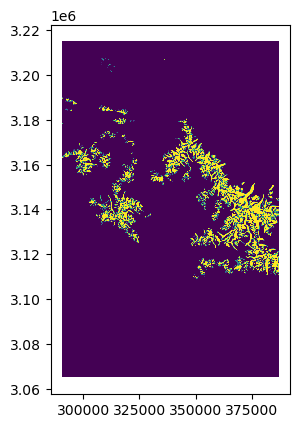

In [170]:
gdf.plot(column = 'rgi7frac', cmap = "viridis")

<Axes: >

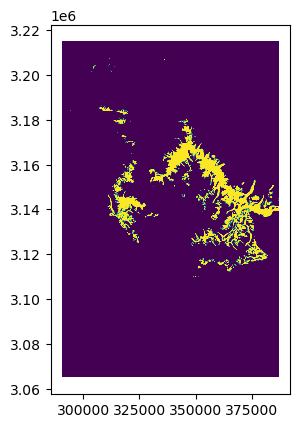

In [171]:
gdf.plot(column = 'glacfrac', cmap = "viridis")

In [172]:
intersection = gpd.overlay(gdf, rgi, how = 'intersection')
intersection

,clone,MOD_ID,glacfrac,glacfrac_ci,glacfrac_db,area_cell,rgi7frac,rgi_id,o1region,o2region,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
0,1,107000,0.0,0.0,0.0,40000.0,0.085993,RGI2000-v7.0-G-15-05925,15,15-01,...,4955.0180,5321.2754,5177.3750,5163.8496,21.151070,88.881485,3,COPDEM30,1129,"POLYGON Z ((350289.000 3109299.000 0.000, 3502..."
1,1,107001,0.0,0.0,0.0,40000.0,0.564873,RGI2000-v7.0-G-15-05925,15,15-01,...,4955.0180,5321.2754,5177.3750,5163.8496,21.151070,88.881485,3,COPDEM30,1129,"POLYGON Z ((350489.000 3109299.000 0.000, 3504..."
2,1,107002,0.0,0.0,0.0,40000.0,0.707029,RGI2000-v7.0-G-15-05925,15,15-01,...,4955.0180,5321.2754,5177.3750,5163.8496,21.151070,88.881485,3,COPDEM30,1129,"POLYGON Z ((350689.000 3109299.000 0.000, 3506..."
3,1,107003,0.0,0.0,0.0,40000.0,0.186641,RGI2000-v7.0-G-15-05925,15,15-01,...,4955.0180,5321.2754,5177.3750,5163.8496,21.151070,88.881485,3,COPDEM30,1129,"POLYGON Z ((350832.048 3109299.000 0.000, 3508..."
4,1,107484,0.0,0.0,0.0,40000.0,0.035113,RGI2000-v7.0-G-15-05925,15,15-01,...,4955.0180,5321.2754,5177.3750,5163.8496,21.151070,88.881485,3,COPDEM30,1129,"POLYGON Z ((350089.000 3109499.000 0.000, 3500..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47292,1,344933,0.0,0.0,0.0,40000.0,0.273398,RGI2000-v7.0-G-15-06040,15,15-01,...,5663.4250,5743.4470,5692.2812,5691.4424,12.578732,352.463300,1,COPDEM30,419,"POLYGON Z ((309889.000 3207299.000 0.000, 3097..."
47293,1,344934,0.0,0.0,0.0,40000.0,0.042013,RGI2000-v7.0-G-15-06040,15,15-01,...,5663.4250,5743.4470,5692.2812,5691.4424,12.578732,352.463300,1,COPDEM30,419,"POLYGON Z ((309889.000 3207299.000 0.000, 3098..."
47294,1,345409,0.0,0.0,0.0,40000.0,0.000164,RGI2000-v7.0-G-15-06042,15,15-01,...,5663.3994,5919.0674,5735.3135,5741.1724,19.741426,29.916254,2,COPDEM30,737,"POLYGON Z ((308049.838 3207499.000 0.000, 3080..."
47295,1,345410,0.0,0.0,0.0,40000.0,0.105618,RGI2000-v7.0-G-15-06042,15,15-01,...,5663.3994,5919.0674,5735.3135,5741.1724,19.741426,29.916254,2,COPDEM30,737,"POLYGON Z ((308289.000 3207499.000 0.000, 3081..."


# SCRATCH CODE BELOW ---------

In [128]:
# calculate fraction for cells with overlap
merged_gdf_nona = merged_gdf[merged_gdf['geometry_rgi'].notna()]


In [131]:
merged_gdf_nona.geometry_gdf

106999    POLYGON ((350089.000 3109299.000, 350289.000 3...
107000    POLYGON ((350289.000 3109299.000, 350489.000 3...
107001    POLYGON ((350489.000 3109299.000, 350689.000 3...
107002    POLYGON ((350689.000 3109299.000, 350889.000 3...
107483    POLYGON ((349889.000 3109499.000, 350089.000 3...
                                ...                        
348207    POLYGON ((309689.000 3207499.000, 309889.000 3...
348208    POLYGON ((309889.000 3207499.000, 310089.000 3...
348683    POLYGON ((307889.000 3207699.000, 308089.000 3...
348684    POLYGON ((308089.000 3207699.000, 308289.000 3...
348685    POLYGON ((308289.000 3207699.000, 308489.000 3...
Name: geometry_gdf, Length: 40343, dtype: geometry

In [ ]:
merged_gdf_nona['rgi7frac'] = merged_gdf_nona.geometry_rgi.area / merged_gdf_nona.geometry_gdf.area

In [ ]:
for index in gdf.index():

In [103]:
# loop through grid cells and compute intersection
gdf['rgi7frac'] = float('nan') # initialize new variable to hold RGI v7 glacier fraction

for index, row in gdf.iterrows():
    gdf_cell = gdf.iloc[[index]]
    intersection = gpd.overlay(rgi, gdf_cell, how='intersection')

    if not intersection.empty:
        intersection_area = intersection.geometry.area.iloc[0]
        gdf_cell_area = gdf_cell.geometry.area.iloc[0]
        rgi_area = rgi.geometry.area.iloc[0]
        
        # Compute the percent overlap
        frac_overlap = (intersection_area / gdf_cell_area)

    else:
        frac_overlap = 0.0  # No overlap with any polygons
        
    # Assign the calculated value to 'rgi7frac'
    gdf.at[index, 'rgi7frac'] = frac_overlap

KeyboardInterrupt: 

<Axes: >

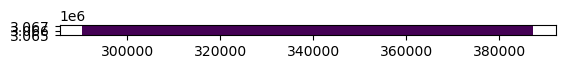

In [104]:
gdf.plot(column = 'rgi7frac', cmap = "viridis")

In [95]:
gdf1 = gdf.iloc[[108451]]
gdf2 = rgi
intersection = gpd.overlay(gdf2, gdf1, how='intersection')

# Calculate the area of the intersection and individual polygons
intersection_area = intersection.geometry.area.iloc[0]
gdf1_area = gdf1.geometry.area.iloc[0]
gdf2_area = gdf2.geometry.area.iloc[0]

# Compute the percent overlap
frac_overlap = (intersection_area / gdf1_area)


In [96]:
gdf1_area

40000.0

In [97]:
gdf2_area

33202.4547855953

In [98]:
intersection_area

24628.307299559685

In [99]:
frac_overlap

0.6157076824889921

In [16]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio

# read in RGI (set to South Asia East region)
rgi = gpd.read_file(r'/Users/brom374/Library/CloudStorage/OneDrive-PNNL/Documents/Datasets/RGI/RGI2000-v7.0-G-global/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp').to_crs('epsg:' + str(epsg))
